In [1]:
import scanpy as sc
import pandas as pd
import scrublet as scr
import scherlock

In [2]:
#########################
######################### Read the data
#########################

adata = sc.read_h5ad("orig/gex/matrix.mtx.h5ad")
#adata = sc.read_h5ad("gex/or10x_gex.h5ad")

adata.var_names_make_unique()
adata.obs["sampleid"] = "sample1"

# remove doublet
#scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.05)
#adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
#print("Got #cells after scrublet "+str(adata.n_obs)) 

# annotate the group of mitochondrial genes as 'mt'. Only keep cells with few MT reads
adata.var['mt'] = adata.var["gene_names"].str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)
#adata = adata[adata.obs.pct_counts_mt < 10, :].copy()  
#print("Got #cells after MT filter "+str(adata.n_obs)) 

# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e6)    

# Move to log counts
sc.pp.log1p(adata) 

### Store what we have now, somewhat raw (CPM-normalized and pseudo-log)
adata.raw=adata

... storing 'sampleid' as categorical


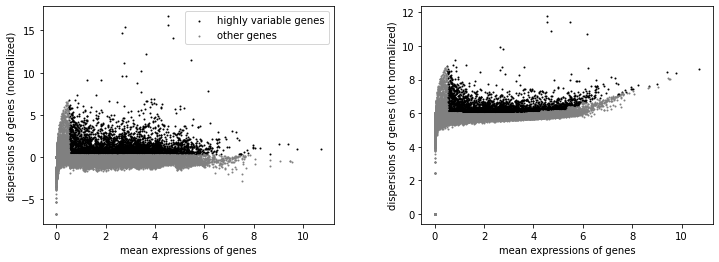

4299
4295


/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


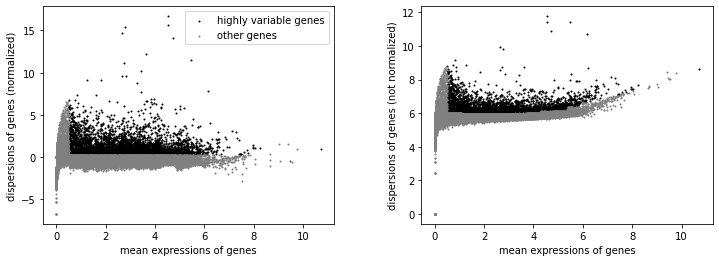

Highly variable genes: 4295


/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [3]:
###################### New highly variable gene selection ###############

def findHighlyVariable(adata):
    #### Create an object to figure out highly variable genes.
    adata2 = sc.AnnData(X=adata.raw.X, 
                        var=adata.raw.var,
                        obs = adata.obs)

    mitochondrial_genes = adata2.var_names[adata2.var["gene_names"].str.startswith('MT-')].tolist()

    #Figure out the variable genes for the full dataset
    sc.pp.highly_variable_genes(adata2, min_mean=0.5, max_mean=20, min_disp=0.3, batch_key = 'sampleid')
    sc.pl.highly_variable_genes(adata2)
    print(len(adata2.var["highly_variable"][adata2.var["highly_variable"] == True].copy()))

    # Exclude the mitochondrial genes
    for i,g in enumerate(adata2.var.highly_variable.index.values.tolist()):
        if g in mitochondrial_genes:
            adata2.var.highly_variable[g] = False
    print(len(adata2.var["highly_variable"][adata2.var["highly_variable"] == True].copy()))

    # Show what's left
    sc.pl.highly_variable_genes(adata2)
    print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

    ## Final decision: which genes to consider highly variable
    var_genes = adata2.var.highly_variable[adata2.var.highly_variable == True].copy().index
    adata.var.highly_variable=adata2.var.highly_variable

    return(var_genes)

var_genes=findHighlyVariable(adata)


In [4]:
#Calculate neighbour graph
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/mahogny/miniconda3/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/mahogny/miniconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/lib/python3.7/site-packa

... storing 'sampleid' as categorical


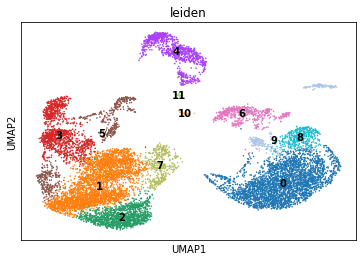

In [5]:
### Perform the clustering
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=[
    'leiden'], 
    legend_loc = 'on data',
    ncols=2)


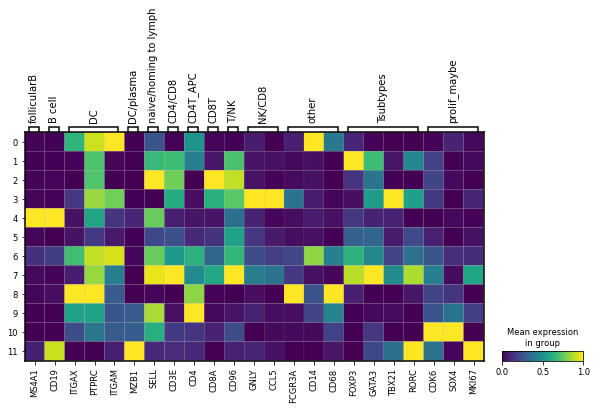

In [6]:
marker_genes = {
'follicularB':['MS4A1'], #this is CD20
'B cell':['CD19'],
'DC':['ITGAX','PTPRC','ITGAM'],
'DC/plasma':['MZB1'],
'naive/homing to lymph':['SELL'],    
'CD4/CD8':['CD3E'],
'CD4T_APC':['CD4'], 
'CD8T':['CD8A'],
'T/NK':['CD96'],
'NK/CD8':['GNLY','CCL5'],
'other':['FCGR3A','CD14','CD68'], #monocyte family?
'Tsubtypes':['FOXP3','GATA3','TBX21','RORC'],
'prolif_maybe':['CDK6','SOX4','MKI67']
    
#https://www.immunopaedia.org.za/breaking-news/2018-articles/are-alveolar-macrophages-m1-or-m2-polarised/    
    
#Monocytes express typical blood monocyte markers, such as CD14, CD11b, CCR2, and CD16, but at extravascular sites they possess higher levels of CD141, CD11c, HLA-DR, and CCR7    
#CST3: Group enriched (myeloid DC, intermediate monocyte, classical monocyte, plasmacytoid DC, non-classical monocyte) 
    
}
marker_gene_names = [j for i in marker_genes.values() for j in i]
sc.pl.matrixplot(adata, marker_genes, groupby='leiden', gene_symbols="gene_names",
                 use_raw = True, show = True, standard_scale="var")


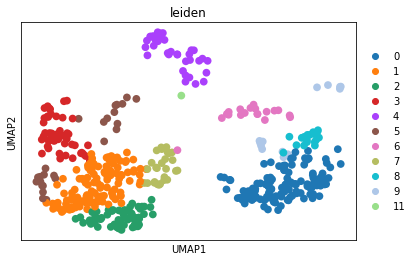

In [7]:
sc.pl.umap(adata[1:500,:], color=[
    'leiden',
], gene_symbols="gene_names",
    ncols=2)

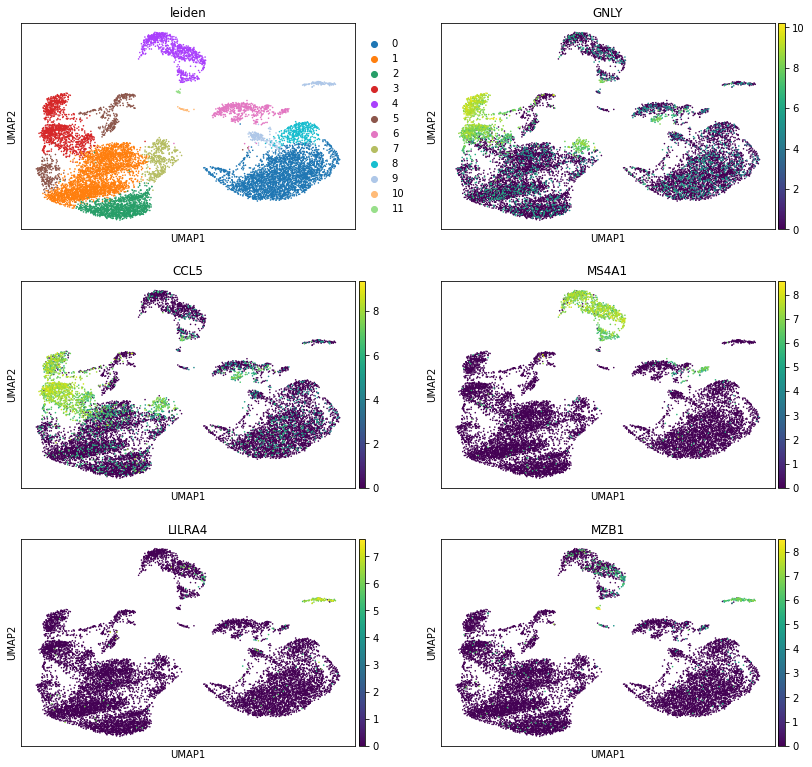

In [8]:
#https://ars.els-cdn.com/content/image/1-s2.0-S0301472X18308051-gr1_lrg.jpg

sc.pl.umap(adata, color=[
    'leiden',
 
    #https://ars.els-cdn.com/content/image/1-s2.0-S0301472X18308051-gr1_lrg.jpg
    'GNLY','CCL5',#NK/CD8
    'MS4A1', #follicular B
    
    #'PRDX2','APOC1', #erythroblast -- probably don't have these
    
    'LILRA4', #especially DC?
    'MZB1', #plasma cell and DC
    #'PPBP', #none: megakaryocytes
], gene_symbols="gene_names",
    ncols=2)

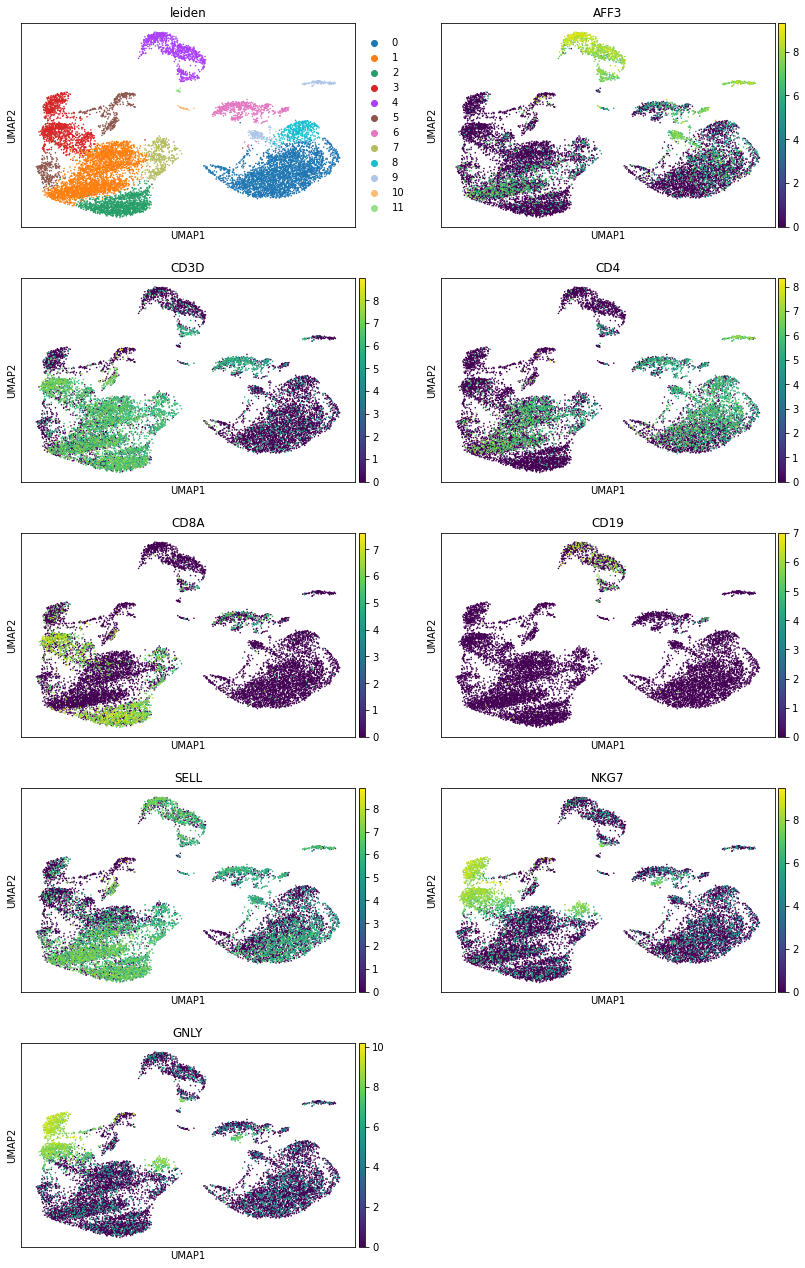

In [9]:
sc.pl.umap(adata, color=[
    'leiden','AFF3',
    
    'CD3D', # T cells
    'CD4', # T cells + APC
    'CD8A', # CD8 T cells
    'CD19', # B cells
    'SELL', # naive / lymphocyte homing
    'NKG7','GNLY', # CD56?+ NK
    
    
    #https://www.nature.com/articles/s41467-019-12464-3
    #T cell dataset we should download and use
    
#'PSAP', #monocyte?
    
#    all DCs express high levels of MHC class II (HLA-DR) and lack typical lineage markers CD3 (T cell), CD19/20 (B cell) and CD56 (natural killer cell)
    
], gene_symbols="gene_names",
    ncols=2)

In [10]:
#ENSG00000120594
#ENSG00000138795
#adata.var

#BCL11B = B cells
#NKG7 = activated T cells and in A-LAK  ... CD8 cytotoxic ... 
#THEMIS = T cell something

#AFF3 = B cells??
#CD74 = ... HLA something

#BACH2 ... 
#IL7R ... CCR7 ... naive?

#https://www.genecards.org/cgi-bin/carddisp.pl?gene=INPP4B


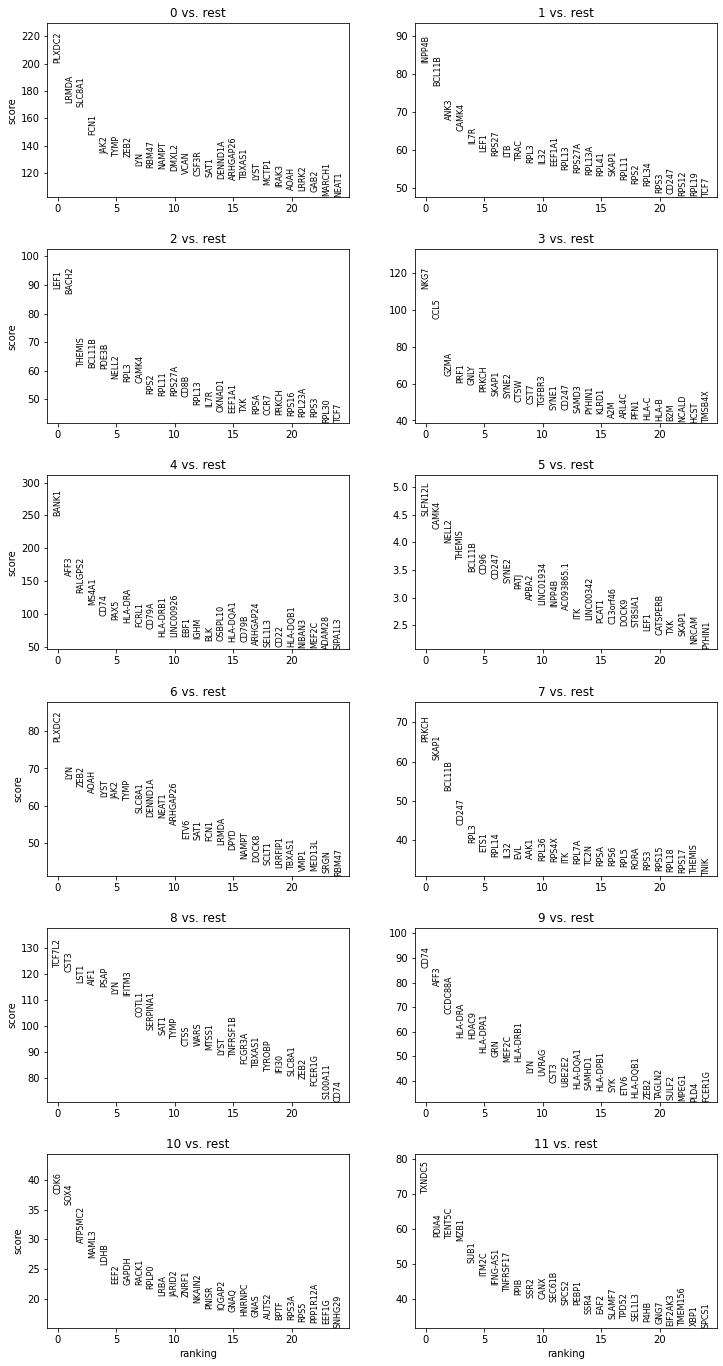

In [11]:
########### find marker genes
#adata.var_names=adata.var["gene_names"]
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols=2,gene_symbols="gene_names")


In [12]:
####################################
## Define the cell types
old_to_new = { 
    "0":"DCish2",
    "1":"CD4T",
    "2":"CD8T",
    "3":"NK",
    "4":"Bcell",
    "5":"Tcellish",
    "6":"DCish",
    "7":"NK2",
    "8":"APC",
    "10":"Bcell_maybe",
    "11":"Bcell_prolif",
}

adata.obs['celltype'] = adata.obs['leiden'].map(old_to_new).astype('category')

In [13]:
import scherlock

In [14]:
subdata = adata[[x in ["Bcell","CD4T"] for x in adata.obs["celltype"]]].copy()

In [15]:
subdata

AnnData object with n_obs × n_vars = 3969 × 36601
    obs: 'origbc', 'sampleid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'gene_names', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
sc.pp.subsample(subdata, n_obs=500, random_state=0, copy=False)

In [17]:
subdata.write_h5ad("reduced/10x_gex_500.h5ad")



In [18]:
############# Write a list of the barcodes
barcodes=pd.DataFrame({'bc':subdata.obs_names.tolist()})
barcodes.to_csv("barcodes2.tsv.gz",header=False,index=False)


In [19]:
#Calculate neighbour graph
sc.tl.pca(subdata, svd_solver='arpack')
sc.pp.neighbors(subdata)

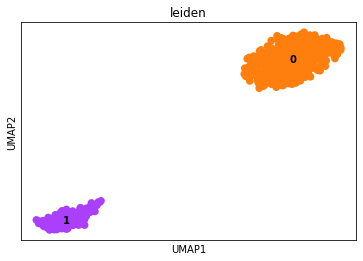

In [20]:
### Perform the clustering
sc.tl.umap(subdata)
sc.tl.leiden(subdata, resolution=0.3)
sc.pl.umap(subdata, color=[
    'leiden'], 
    legend_loc = 'on data',
    ncols=2)


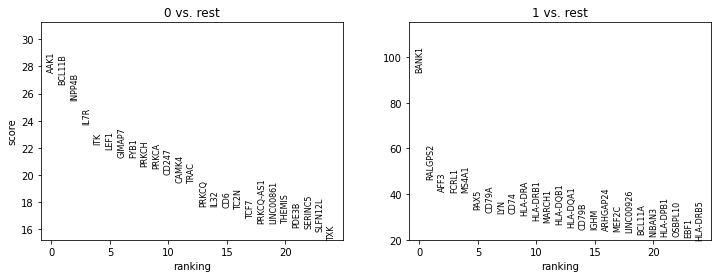

In [21]:
########### find marker genes
#adata.var_names=adata.var["gene_names"]
sc.tl.rank_genes_groups(subdata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(subdata, n_genes=25, sharey=False, ncols=2,gene_symbols="gene_names")
